In [37]:
import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise


from tqdm import tqdm
import scipy


import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg

import math
import torch
import gpytorch

from uci_datasets import Dataset


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()

In [69]:
# squared euclidean distance
def sqeuclidean_distance(x, y):
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func, x, y):
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

def SE_kernel(X, Y, var, length, noise, jitter=1.0e-6, include_noise=True):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, X / length, Y / length
    )

    assert deltaXsq.shape == (X.shape[0], Y.shape[0])

    # rbf function
    K = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        K += (noise + jitter) * jnp.eye(X.shape[0])
    return K


def predict_with_mean(
    X,
    Y,
    X_test,
    var,
    length,
    noise,
    kernel_func=SE_kernel,
    mean_func=lambda x: jnp.zeros(x.shape[0]),
):
    # compute kernels between train and test data, etc.
    k_pp = kernel_func(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel_func(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel_func(X, X, var, length, noise, include_noise=True)
    K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
    K = k_pp - jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, jnp.transpose(k_pX))
    )
    # sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
    #     rng_key, X_test.shape[:1]
    # )
    mean = mean_func(X_test) + jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y - mean_func(X))
    )
    # we return both the posterior mean and std dev at X_test
    return mean, jnp.sqrt(jnp.diag(K))


# Auxiliary functions    
vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))    
matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0)) 

vmap_SE_kernel = jax.vmap(SE_kernel, in_axes=(None, None, 0, 0, 0))
vmap_SE_kernel_also_X = jax.vmap(SE_kernel, in_axes=(0, 0, 0, 0, 0))


# vmapped_pred_with_mean = jax.vmap(
#     predict_with_mean, in_axes=(None, None, 0, None, 0, 0, 0, None, None)
# )

# vmapped_pred_with_mean = jax.vmap(
#     vmapped_pred_with_mean,
#     in_axes=(None, None, 1, None, 1, 1, 1, None, None),
# )

def compute_diag_inv_batch(A_batch):
    def compute_diag_inv(A):
        # Cholesky factorization of A
        L, lower = linalg.cho_factor(A)
        
        # Identity matrix
        I = jnp.eye(A.shape[0])
        
        # Function to compute a single element of the diagonal of A^{-1}
        def diag_element(e_i,i):
            return linalg.cho_solve((L, lower), e_i)[i]
        
        # Compute diagonal elements using vmap
        diag_elements = jax.vmap(lambda i: diag_element(I[i],i))(jnp.arange(A.shape[0]))
        return diag_elements

    # Vectorize over the batch dimension
    diag_inv_batch = jax.vmap(compute_diag_inv)(A_batch)
    
    return diag_inv_batch

In [225]:
def joint_loo_loss(X, M, proj_dim, y, normalize_weights = False, y_test = None, X_test = None): # M is the number of GP experts
    N,DIM = X.shape

    # ====== Obtain the projected training inputs ===== #
    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    assert X_reps.shape == (M,N,DIM)

    P_projs = jax.random.normal(jax.random.PRNGKey(42), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

    with numpyro.plate("DIM", DIM):
        ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0))
    assert ell.shape == (DIM,)
    # ell = jnp.ones((DIM,))
    
    X_projs = matmul_vmapped(X_reps, P_projs / ell[None, :, None])
    assert (ell[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)


    # ====== GP experts ====== #
    with numpyro.plate("M", M,dim=-2):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))
        with numpyro.plate("proj_dim", proj_dim,dim=-1):
            kernel_length = numpyro.sample("kernel_length", dist.HalfNormal(scale = 1.0))

    # kernel_var = kernel_var.squeeze()
    # kernel_noise = kernel_noise.squeeze()
    assert kernel_var.shape == (M,1)
    assert kernel_length.shape == (M,proj_dim)
    assert kernel_noise.shape == (M,1)    

    # covariance matrices
    vmap_SE_kernel_also_X = jax.vmap(SE_kernel, in_axes=(0, 0, 0, 0, 0))
    K = numpyro.deterministic(
        "K", vmap_SE_kernel_also_X(X_projs, X_projs, kernel_var, kernel_length, kernel_noise)
    )
    assert K.shape == (M,N,N)

    # ====== We now compute the mu_loo and prec_loo vectors of each expert ===== #
    # Step 1: compute the cholesky factor of each K
    chol_factor_vmap = jax.vmap(lambda A: linalg.cho_factor(A,lower=True)[0],in_axes=(0))
    K_chol = chol_factor_vmap(K)
    assert K_chol.shape == (M,N,N)

    # Step 2: compute [alpha_m]_n = [K_m^{-1}y]_n and [K_m^{-1}]_nn for n=1,...,N and m=1,...,M
    chol_solve_vmap = jax.vmap(lambda A,b: linalg.cho_solve((A,True),b), in_axes=(0,None))
    alpha = chol_solve_vmap(K_chol,y)
    assert alpha.shape == (M,N)

    compute_diag = jax.vmap(lambda A,b,i: linalg.cho_solve((A,True),b)[i], in_axes=(None,0,0))
    compute_diag_batch = jax.vmap(lambda A: compute_diag(A,jnp.eye(A.shape[0]), jnp.arange(A.shape[0])),in_axes=(0))

    # diag_inv_K = compute_diag_inv_batch(K)        # in this one we don't have to pass the cholesky factor
    diag_inv_K = compute_diag_batch(K_chol)         # la mia tambien funciona!
    assert diag_inv_K.shape == (M,N)

    # Step 3: compute loo posterior mean and precision of all the experts
    mu_ex = jnp.broadcast_to(y,(M,N)) - alpha/diag_inv_K
    tau_ex = diag_inv_K 
    assert mu_ex.shape == (M,N)
    assert tau_ex.shape == (M,N)


    # ====== log-linear fusion with weights ====== #
    w_ex = numpyro.sample("w_ex", dist.HalfNormal(scale=jnp.ones((M,)))) # we learn a unique weight for each expert
    assert w_ex.shape == (M,)
    
    if normalize_weights:  # w needs to have shape = (M,Ndata)   
        w = numpyro.deterministic("w", jnp.tile(jnp.reshape(w_ex, (-1, 1)), N)/jnp.sum(w_ex.squeeze()))   # normalized
    else:
        w = numpyro.deterministic("w", jnp.tile(jnp.reshape(w_ex, (-1, 1)), N))
    assert w.shape == (M,N)

    w  = w.T
    assert w.shape == (N,M)

    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mu_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    numpyro.sample(
        "y",
        dist.Normal(loc=mu_fused, scale=std_fused,),
        obs=jnp.squeeze(y),
    )

    if y_test is not None and X_test is not None:   # prediction mode
        # we first make sure that the first dimension of hyperparameters is the expert dimension (i.e. length M)
        if kernel_var.shape[1] > 1:
            kernel_var = kernel_var.squeeze()
            kernel_length = kernel_var.squeeze()
            kernel_noise = kernel_var.squeeze()
    
        assert kernel_var.shape[0] == M
        assert kernel_length.shape[0] == M
        assert kernel_noise.shape[0] == M

        # Make sure to pass test inputs, namely, X_test
        X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
        X_projs_test = matmul_vmapped(X_reps_test, P_projs / ell[None, :, None])
        my_predict = jax.vmap(predict_with_mean, in_axes=(0,None,0,0,0,0))
        mus, stds = my_predict(X_projs,y,X_projs_test,kernel_var,kernel_length,kernel_noise)

        # print(mus.shape, stds.shape, X_projs.shape, X_projs_test.shape)
        
        taus = 1 / stds**2

        if normalize_weights:  # w needs to have shape = (M,Ndata)   
            w = jnp.tile(jnp.reshape(w_ex, (-1, 1)), X_test.shape[0])/jnp.sum(w_ex.squeeze())   # normalized
        else:
            w = jnp.tile(jnp.reshape(w_ex, (-1, 1)), X_test.shape[0])
        assert w.shape == (M,X_test.shape[0])

        w  = w.T


        assert mus.shape == (M,X_test.shape[0])
        assert taus.shape == (M,X_test.shape[0])
        assert w.shape == (X_test.shape[0],M)

        tau_fused_test = numpyro.deterministic(
        "tau_fused_test", jnp.einsum("nm,mn->m", taus, w)
        )  

        mu_fused_test = numpyro.deterministic(
        "mu_fused_test", jnp.einsum("nm,nm,mn->m", taus, mus, w) / tau_fused_test
        )  
    
        std_fused_test = numpyro.deterministic("std_fused_test", 1 / jnp.sqrt(tau_fused_test))

        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused_test), scale=jnp.squeeze(std_fused_test),
                )
            )
        


In [226]:
from numpyro.handlers import trace, seed
from numpyro.util import format_shapes

model = joint_loo_loss
exec_trace = trace(seed(model, random.PRNGKey(0))).get_trace(X_train,num_experts,proj_dim,y_train)
print(format_shapes(exec_trace))

     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
         DIM plate    13 |
 lengthscales dist    13 |
             value    13 |
           M plate     5 |
   kernel_var dist 5   1 |
             value 5   1 |
 kernel_noise dist 5   1 |
             value 5   1 |
    proj_dim plate    13 |
kernel_length dist 5  13 |
             value 5  13 |
         w_ex dist     5 |
             value     5 |
            y dist   456 |
             value   456 |


In [227]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[1]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape


# load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

housing dataset, N=506, d=13


In [228]:
model = joint_loo_loss
lr = 0.1
training_iter = 120
num_experts = 5
proj_dim =  X_train.shape[1]


guide = AutoDelta(model, 
                    init_loc_fn = numpyro.infer.initialization.init_to_median,
                    # init_loc_fn = numpyro.infer.initialization.init_to_uniform,
                    # init_loc_fn = numpyro.infer.init_to_sample,
                    )
svi= SVI(model,
        guide,
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        # optim=chain(clip(10.0), adam(0.005)),
        optim = numpyro.optim.Adam(lr),
        loss=Trace_ELBO(num_particles=1),   # default is 1
    )


res = svi.run(
    jax.random.PRNGKey(30),
    training_iter,  
    X=X_train,
    y = y_train,
    M=num_experts,
    proj_dim = proj_dim,
)


params = res.params

100%|██████████| 120/120 [00:46<00:00,  2.57it/s, init loss: 752.3631, avg. loss [115-120]: 79.1321]


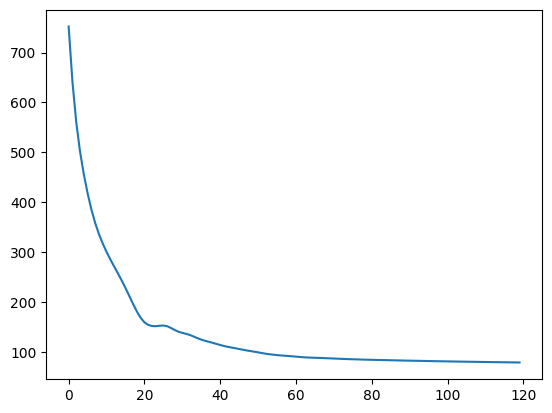

In [229]:
plt.plot(res[2])

In [238]:
model = joint_loo_loss
dist_posterior_predictive = Predictive(model=model,guide=guide, params=params, num_samples=10)
# TRAINING DATA
samples_tr = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                    X=X_train, 
                                    y=y_train, 
                                    M=num_experts,
                                    proj_dim=proj_dim,
                                    y_test=y_train,
                                    X_test = X_train,
                                    )

ymu_tr = samples_tr["mu_fused"].mean(0)
ys_tr = samples_tr["std_fused"].mean(0)
w_tr = samples_tr["w"].mean(0)

nlpd_train = - jnp.mean(
    jax.nn.logsumexp(samples_tr["lpd_point"], axis=0) - jnp.log(samples_tr["lpd_point"].shape[0])
)
rmse_train = np.sqrt(np.mean((ymu_tr.squeeze()-y_train.squeeze())**2))

# TEST DATA
samples_tst = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                    X=X_train, 
                                    y=y_train, 
                                    M=num_experts,
                                    proj_dim = proj_dim,
                                    y_test=y_test,
                                    X_test = X_test,
                                    )

ymu_tst = samples_tst["mu_fused_test"].mean(0)
ys_tst = samples_tst["std_fused_test"].mean(0)
w_tst = samples_tst["w"].mean(0)

nlpd_test = - jnp.mean(
    jax.nn.logsumexp(samples_tst["lpd_point"], axis=0) - jnp.log(samples_tst["lpd_point"].shape[0])
)
rmse_test = np.sqrt(np.mean((ymu_tst.squeeze()-y_test.squeeze())**2))

In [239]:
print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

nlpd train:  -0.6618950822462627
nlpd test:  0.04599416361347986
rmse train:  0.28374976131511714
rmse test:  0.3647655244388756


(30.0, 70.0)

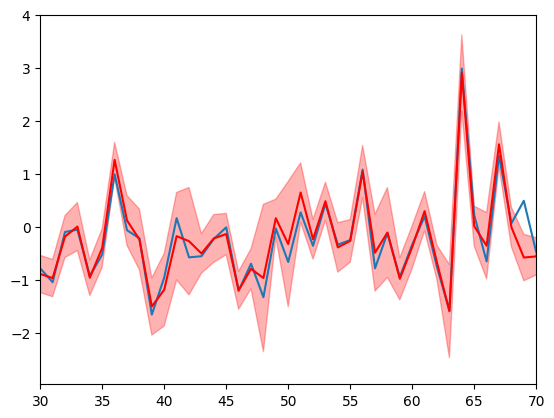

In [232]:
plt.plot(y_train)
plt.plot(ymu_tr, color = "red")
plt.fill_between(np.arange(len(y_train)), ymu_tr + 2*ys_tr,
                 ymu_tr - 2*ys_tr, color = "red", alpha = 0.3)
plt.xlim((30,70))

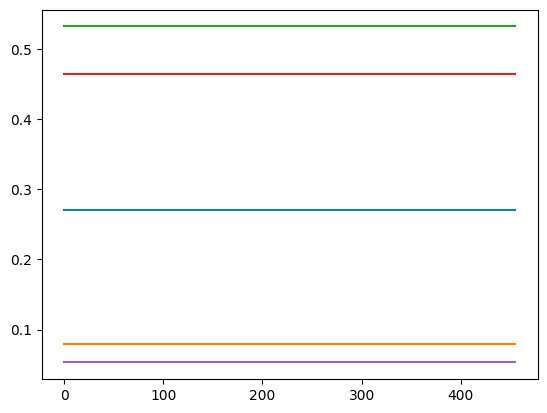

In [233]:
for i in range(num_experts):
    plt.plot(samples_tr["w"].mean(0)[i,:])

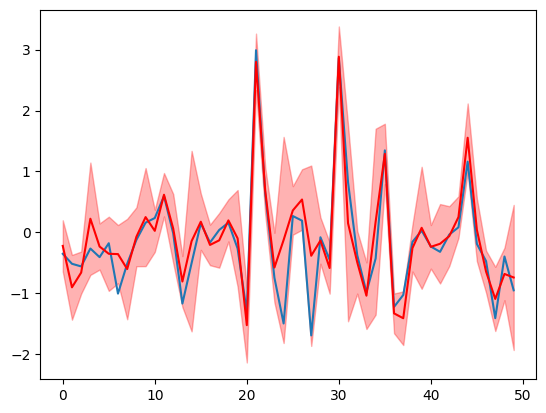

In [234]:
plt.plot(y_test)
plt.plot(ymu_tst, color = "red")
plt.fill_between(np.arange(len(y_test)), ymu_tst + 2*ys_tst,
                 ymu_tst - 2*ys_tst, color = "red", alpha = 0.3)


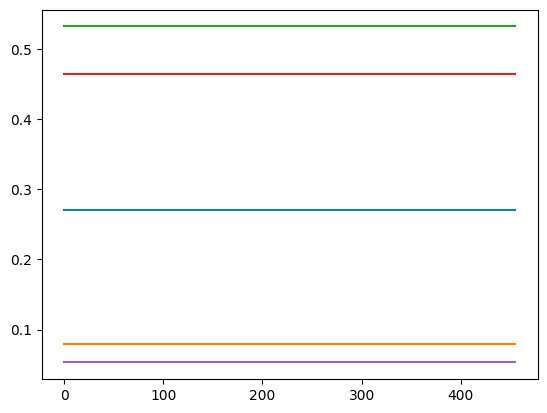

In [235]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])